In [1]:
import os
import sys
import talib as ta
syspath = os.path.split(os.path.abspath("."))[0]
sys.path.append(syspath)
import univ3api.simulation as sim
import univ3api.utils as utils
import importlib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# run if simulation file is updated
importlib.reload(sim)

HOST = "mongodb://172.16.11.81:27017/ETHDATA"
source = sim.DataUtilMongoDB(HOST)

from datetime import datetime
import time
d1 = datetime(2021,5,10, 9)
d2 = datetime(2021,11,10,9)
t1 = int(time.mktime(d1.timetuple()))
t2 = int(time.mktime(d2.timetuple()))

# print(d1.timetuple())
# print(time.mktime(d1.timetuple()))
# print(int(time.mktime(d1.timetuple())))

# swapdata = source.swap_by_time("SWAP_WETH_USDT_3000", t1, t2)
swapdata = source.swap_by_time("SWAP_USDC_WETH_3000", t1, t2)
swapdata.tail()
pricedata = swapdata[["timestamp", "sqrtPriceX96"]]
# pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(18, 6).x96_to_price)
pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(6, 18).x96_to_price)

In [2]:
pricedata_res = pd.read_csv('../../data/usdceth/pricedata_res2021051020211110.csv',index_col=0) 
pricedata_res.dropna(axis=0,how='any',inplace=True)
pricedata_res

,timestamp,sqrtPriceX96,price,SmaLowerLma,VolLowerBelowmaQuantile50,CloseLowerMA,VolHigherOvermaQuantile50Twosigma,revoke_pos
datetime,,,,,,,,
2021-05-10 01:17:52,1620609472,1267554519342589161168659854845874,0.000256,False,False,False,False,True
2021-05-10 01:23:50,1620609830,1267498129839936824485169221023868,0.000256,False,False,False,False,True
2021-05-10 01:24:49,1620609889,1267496927736336268048970777338285,0.000256,False,False,False,False,True
2021-05-10 01:24:49,1620609889,1267496466129159558106023913391909,0.000256,False,False,False,False,True
2021-05-10 01:24:54,1620609894,1267269382521328460205280017540103,0.000256,False,False,False,False,True
...,...,...,...,...,...,...,...,...
2021-11-09 22:08:14,1636495694,1145839722015383138592200977344913,0.000209,True,True,False,False,False
2021-11-09 22:25:53,1636496753,1146879215832066616278059495000000,0.000210,True,True,False,False,False
2021-11-09 22:26:35,1636496795,1146878243649597682678123902956928,0.000210,True,True,False,False,False


In [3]:
init_price = pricedata_res["price"][0]

decimal0 = 6 #USDC的精度
decimal1 = 18 #ETH的精度

init_amount0 = 1000000*1e6 #初始持有USDC的数量
init_amount1 = 0 #初始持有ETH的数量
print('init_price =',init_price)

init_price = 0.0002559611947100053


In [4]:
import Strategy_usdceth_vol_v2
importlib.reload(utils)
importlib.reload(sim)
importlib.reload(Strategy_usdceth_vol_v2)
strategy = Strategy_usdceth_vol_v2.HoldStrategy(init_amount0, init_amount1, decimal0, decimal1, sim.PoolFee.low, True)
strategy.init(swapdata.iloc[0].to_dict())

# strategy.run(swapdata, priceDt)
strategy.run(swapdata, pricedata_res)

report = strategy.report()

**********************【Price Over MA】【创建Long Vol池子】【第1次建池】***********************************
转换后钱包中余额 amount0:  449725000000.0 amount1:  140631495516086534144
price:  0.0002559611947100053
$$$$$$$【Upper Price】: 0.00033005978975935465
$$$$$$$【Lower Price】: 0.00019849777291908478
######【L】:60666448444272064【USDC】:449725000000【ETH】:117247551451873394688
将要投入池子的数量 amount_t0: 449725000000 amount_t1: 117247551451873165312
【RealWorldTime】:2021-05-10 09:17:52, Timestamp: 1620609472, Blocknumber: 12403600
Mint position： Position(L=60665339031571984, tick=[191040, 196140], range=[3035.1064, 5054.2070])
【Mint amount】: token0=449708.399096, token1=117.24755145187316
Wallet amount: token0=16.600904, token1=23.38394406421337
******************************************【撤销池子】【原因:OverMA与VolHigherQuantile50TwoSigma条件不满足】****************************
CloseLowerMA: False, VolHigherQuantile50TwoSigma: True
Price(0.00024235473074171444) out of range(0.00019849777291908478, 0.00033005978975935465)
【RealWorldT

In [5]:
positions = report.positions
positions

{1: <univ3api.simulation.PositionReport at 0x21d4d4654a8>,
 2: <univ3api.simulation.PositionReport at 0x21d4d465be0>,
 3: <univ3api.simulation.PositionReport at 0x21d4d4659e8>,
 4: <univ3api.simulation.PositionReport at 0x21d4d465630>,
 5: <univ3api.simulation.PositionReport at 0x21d4d470ef0>,
 6: <univ3api.simulation.PositionReport at 0x21d4d470588>,
 7: <univ3api.simulation.PositionReport at 0x21d4d4708d0>}

In [6]:
positions[5].get_balance(plain=True, draw_plot=True)

,datetime,amount0,fee0,cumFee0,collectedFee0,amount1,fee1,cumFee1,collectedFee1
0,2021-09-01 13:11:43,555067.319139,0.000000,0.000000,0.000000,166.447,0.000000,0.000000,0.000000
1,2021-09-01 13:13:23,556633.532079,0.783106,0.783106,0.783106,165.996,0.000000,0.000000,0.000000
2,2021-09-01 13:13:23,556802.907224,0.084687,0.867793,0.867793,165.947,0.000000,0.000000,0.000000
3,2021-09-01 13:13:23,557244.345771,0.220719,1.088512,1.088512,165.82,0.000000,0.000000,0.000000
4,2021-09-01 13:14:15,558027.452241,0.391553,1.480065,1.480065,165.595,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
8253,2021-09-20 06:50:32,431062.442384,0.479606,4003.000786,4003.000786,203.09,0.000000,1.170735,1.170735
8254,2021-09-20 06:50:33,433681.333981,1.309445,4004.310231,4004.310231,202.295,0.000000,1.170735,1.170735
8255,2021-09-20 06:51:19,434910.430838,0.614548,4004.924779,4004.924779,201.923,0.000000,1.170735,1.170735
8256,2021-09-20 06:55:58,434504.506811,0.000000,4004.924779,4004.924779,202.046,0.000061,1.170796,1.170796


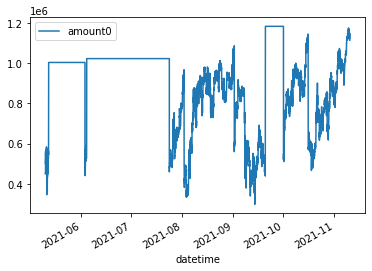

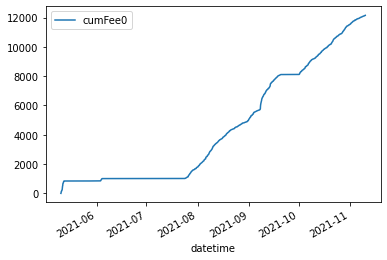

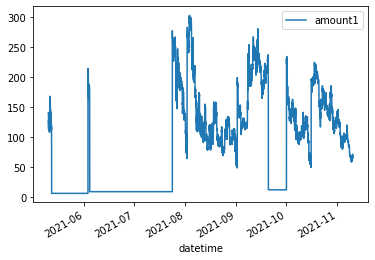

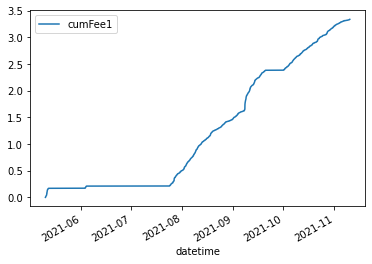

In [7]:
total_balance = report.total_balance(draw_plot=True, plain=True)

<AxesSubplot:>

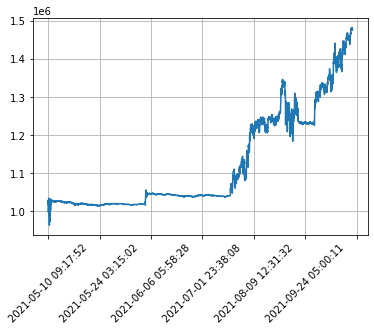

In [8]:
price = pricedata.drop_duplicates("timestamp").set_index("timestamp")["price"]
price
usdc_balance = total_balance.set_index("timestamp")[["amount0", "cumFee0"]].sum(axis=1)
eth_balance = total_balance.set_index("timestamp")[["amount1", "cumFee1"]].sum(axis=1) / price
eth_balance+usdc_balance
# eth_balance.plot()
# usdt_balance.plot()
tb_Timing = (eth_balance+usdc_balance)
tb_Timing_origin = tb_Timing.copy(deep=True)
time_to_print = list(map(time.localtime,tb_Timing.index.tolist()))
time_to_print_2  = [time.strftime('%Y-%m-%d %H:%M:%S', i) for i in time_to_print]
# time_to_print_2  = [time.strftime('%Y-%m-%d', i) for i in time_to_print]
tb_Timing.index = time_to_print_2
tb_Timing.plot(rot = 45,grid=True)
# tb_Timing.to_csv('../../data/usdceth/tb_timing_v2.csv')
# tb_Timing_origin.to_csv('../../data/usdceth/tb_timing_origin_v2.csv')

In [12]:
eth_balance
eth_balance_df = pd.DataFrame(eth_balance)
eth_balance_df.columns = ['eth_balance']
eth_balance_df

,eth_balance
timestamp,
1620609472,549425.062949
1620609830,549305.247193
1620609889,549301.311704
1620609894,548818.966510
1620610623,549850.784613
...,...
1636505114,341446.896040
1636505262,341694.520475
1636505287,341705.502038


In [13]:
usdc_balance
usdc_balance_df = pd.DataFrame(usdc_balance)
usdc_balance_df.columns = ['usdc_balance']
usdc_balance_df

,usdc_balance
timestamp,
1620609472,4.497250e+05
1620609830,4.498939e+05
1620609889,4.498988e+05
1620609894,4.505790e+05
1620610623,4.491283e+05
...,...
1636505114,1.135179e+06
1636505262,1.134897e+06
1636505287,1.134884e+06


In [21]:
# tb_Timing.resample('D').sum()
pd.to_datetime(tb_Timing.index.tolist()[0])
tb_Timing.index = pd.to_datetime(tb_Timing.index)
tb_Timing.resample('D').sum()

2021-05-10    3.697467e+08
2021-05-11    6.368492e+08
2021-05-12    4.544761e+08
2021-05-13    1.304236e+09
2021-05-14    1.050996e+09
                  ...     
2021-11-06    4.554132e+08
2021-11-07    4.010244e+08
2021-11-08    3.826679e+08
2021-11-09    4.632538e+08
2021-11-10    2.350095e+08
Freq: D, Length: 185, dtype: float64